Calculates high pass phase for each pixel. 
<br><br>
Written 10-17-23 to reproduce the hpcor.r4 file that Rowena had made.
***
***

In [1]:
# import stuff
import os,sys
import glob
from osgeo import gdal
import datetime 
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
%matplotlib  widget

Load Rowena's version of the hp phase map to compare to mine. 

In [2]:
file_name = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/hpcor.r4' 
f1 = gdal.Open(file_name, gdal.GA_ReadOnly)
hp = f1.ReadAsArray(); f1 = None
print('hp phase for each pixel loaded.')

hp phase for each pixel loaded.


In [3]:
dir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'  

# bounding coords of region of interest: larger area at tip of LS 
x1 = 18000
y1 = 2100
x2 = 14000
y2 = 1000
# shape of unwrapped igrams
dx = x1-x2
dy = y1-y2

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(dir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1

# this will accumulate hp phs for each igram then can divide by numIgrams at end 
hp_phs = np.zeros((dy,dx),dtype='complex')
# filter size
alooks=4
rlooks=20

# loop through the dates 
for i in range(numIgrams-1): # 211 SLCs, 210 igrams, 209 triplets 
    dateA=dates[i]
    dateB=dates[i+1]
    # load SLC A (complex)
    ds = gdal.Open(dir+"/SLC_vv/"+dateA+"/"+dateA+".slc.full", gdal.GA_ReadOnly)
    slcA = ds.GetRasterBand(1).ReadAsArray(x2,y2,dx,dy)
    # load SLC B (complex)
    ds = gdal.Open(dir+"/SLC_vv/"+dateB+"/"+dateB+".slc.full", gdal.GA_ReadOnly)
    slcB = ds.GetRasterBand(1).ReadAsArray(x2,y2,dx,dy)
    # make the interferogram
    intAB = slcA * np.conj(slcB)
    #filter the igram: real part, then imaginary part 
    filtintr = gaussian_filter(np.real(intAB),sigma=[alooks/4,rlooks/4])
    filtinti = gaussian_filter(np.imag(intAB),sigma=[alooks/4,rlooks/4])
    filtAB = filtintr+1j*filtinti
    # take phase of full res igram minus filtered version 
    phs_diff = np.angle(intAB) - np.angle(filtAB)
    # make it complex again 
    hp_phs += np.exp(1j*phs_diff)
# take abs value of each and divide by number of igrams
hp_phs = np.abs(hp_phs)/numIgrams

Plot my version next to Rowena's and compare.

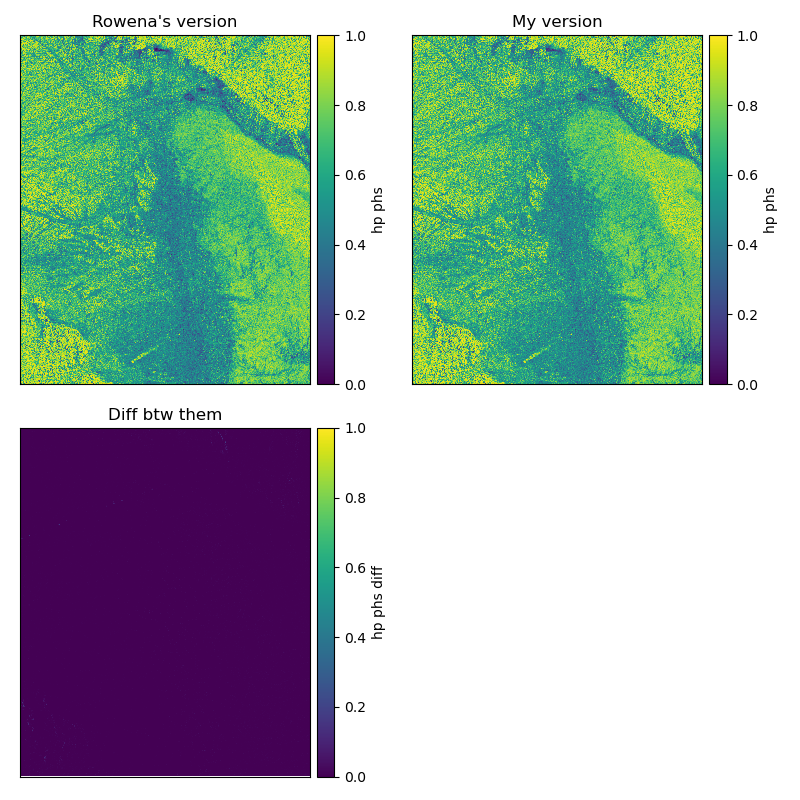

In [4]:
plt.figure(figsize=(8,8),tight_layout=True)
plt.subplot(2,2,1)
plt.imshow(hp[y2:y1,x2:x1], aspect='auto',interpolation='nearest',vmin=0,vmax=1)
plt.colorbar(orientation='vertical',pad=0.02,label='hp phs')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Rowena\'s version')
plt.subplot(2,2,2)
plt.imshow(hp_phs, aspect='auto',interpolation='nearest',vmin=0,vmax=1)
plt.colorbar(orientation='vertical',pad=0.02,label='hp phs')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('My version')
plt.subplot(2,2,3)
plt.imshow(hp[y2:y1,x2:x1]-hp_phs, aspect='auto',interpolation='nearest',vmin=0,vmax=1)
plt.colorbar(orientation='vertical',pad=0.02,label='hp phs diff')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Diff btw them')
plt.show()

Save it. Only run once.

In [19]:
driver=gdal.GetDriverByName('ISCE')
fileName = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/hp_phs.r4'
colds = driver.Create(fileName,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(hp_phs)
colds=None
print('hp phase file saved.')

hp phase file saved.
